## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns =['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'diffusivity', 'temp_initial00', 'temp_heat01', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns =  ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',  'temp_initial00', 'temp_heat01', 'temp_total05', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns =['depth', 'day_of_year', 'time_of_day','ice', 'snow', 'snowice', 'temp_initial00', 'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.015955927
RMSE of after m1 0.019903485
RMSE of after m3 0.07817939
RMSE of after m4 0.07870821
RMSE of after m0 0.014518581
RMSE of after m1 0.055837248
RMSE of after m3 0.1477848
RMSE of after m4 0.14640383
RMSE of after m0 0.022985889
RMSE of after m1 0.04009601
RMSE of after m3 0.089379124
RMSE of after m4 0.09203076
RMSE of after m0 0.023267046
RMSE of after m1 0.02467512
RMSE of after m3 0.090026364
RMSE of after m4 0.09087419
RMSE of after m0 0.020757074
RMSE of after m1 0.02009003
RMSE of after m3 0.01690196
RMSE of after m4 0.017224463
RMSE of after m0 0.019228224
RMSE of after m1 0.016826741
RMSE of after m3 0.011024926
RMSE of after m4 0.011710198
RMSE of after m0 0.018557398
RMSE of after m1 0.015764339
RMSE of after m3 0.009375972
RMSE of after m4 0.009957707
RMSE of after m0 0.018134614
RMSE of after m1 0.015549683
RMSE of after m3 0.010425117
RMSE of after m4 0.010811509
RMSE of after m0 0.01839736
RMSE of after m1 0.016086038
RMSE of after m3 0.0113804

RMSE of after m0 0.015118729
RMSE of after m1 0.023506418
RMSE of after m3 0.18972333
RMSE of after m4 0.18658829
RMSE of after m0 0.007792614
RMSE of after m1 0.008576836
RMSE of after m3 0.026381249
RMSE of after m4 0.0243727
RMSE of after m0 0.009526869
RMSE of after m1 0.010083725
RMSE of after m3 0.0421065
RMSE of after m4 0.046019692
RMSE of after m0 0.009393042
RMSE of after m1 0.011325409
RMSE of after m3 0.030858874
RMSE of after m4 0.029808799
RMSE of after m0 0.010285034
RMSE of after m1 0.013249002
RMSE of after m3 0.06625607
RMSE of after m4 0.065137625
RMSE of after m0 0.009125734
RMSE of after m1 0.0137356585
RMSE of after m3 0.033011626
RMSE of after m4 0.037946906
RMSE of after m0 0.008596247
RMSE of after m1 0.014596719
RMSE of after m3 0.036350157
RMSE of after m4 0.041545812
RMSE of after m0 0.0072846273
RMSE of after m1 0.012779305
RMSE of after m3 0.03178859
RMSE of after m4 0.03515794
RMSE of after m0 0.008523658
RMSE of after m1 0.012053964
RMSE of after m3 0.02

RMSE of after m1 0.0203582
RMSE of after m3 0.056777872
RMSE of after m4 0.067501836
RMSE of after m0 0.010631618
RMSE of after m1 0.01966602
RMSE of after m3 0.039865687
RMSE of after m4 0.05110483
RMSE of after m0 0.0087290825
RMSE of after m1 0.012664626
RMSE of after m3 0.059154622
RMSE of after m4 0.058914714
RMSE of after m0 0.008423593
RMSE of after m1 0.011023106
RMSE of after m3 0.032184675
RMSE of after m4 0.033398196
RMSE of after m0 0.008955818
RMSE of after m1 0.0125395
RMSE of after m3 0.032101102
RMSE of after m4 0.030934839
RMSE of after m0 0.009285526
RMSE of after m1 0.013135058
RMSE of after m3 0.0367191
RMSE of after m4 0.029565418
RMSE of after m0 0.008633956
RMSE of after m1 0.013235392
RMSE of after m3 0.045276586
RMSE of after m4 0.04342015
RMSE of after m0 0.008147257
RMSE of after m1 0.014740954
RMSE of after m3 0.039076567
RMSE of after m4 0.043398574
RMSE of after m0 0.008542743
RMSE of after m1 0.014813299
RMSE of after m3 0.035930037
RMSE of after m4 0.041

RMSE of after m1 0.01973575
RMSE of after m3 0.060843296
RMSE of after m4 0.073231846
RMSE of after m0 0.010710784
RMSE of after m1 0.018394949
RMSE of after m3 0.033981673
RMSE of after m4 0.042168103
RMSE of after m0 0.011086333
RMSE of after m1 0.018880406
RMSE of after m3 0.044725478
RMSE of after m4 0.051928136
RMSE of after m0 0.010200146
RMSE of after m1 0.017566849
RMSE of after m3 0.04154266
RMSE of after m4 0.051512685
RMSE of after m0 0.010232318
RMSE of after m1 0.016298868
RMSE of after m3 0.055421673
RMSE of after m4 0.054696646
RMSE of after m0 0.009686386
RMSE of after m1 0.016881678
RMSE of after m3 0.03343277
RMSE of after m4 0.033455856
RMSE of after m0 0.00901501
RMSE of after m1 0.016258543
RMSE of after m3 0.01885481
RMSE of after m4 0.026000394
RMSE of after m0 0.008773983
RMSE of after m1 0.015119097
RMSE of after m3 0.015271945
RMSE of after m4 0.025602622
RMSE of after m0 0.0101601975
RMSE of after m1 0.01642088
RMSE of after m3 0.018434076
RMSE of after m4 0.

RMSE of after m1 0.008814336
RMSE of after m3 0.021731783
RMSE of after m4 0.022703491
RMSE of after m0 0.008615068
RMSE of after m1 0.010362035
RMSE of after m3 0.051753167
RMSE of after m4 0.047657836
RMSE of after m0 0.008422314
RMSE of after m1 0.009612177
RMSE of after m3 0.034312014
RMSE of after m4 0.03527085
RMSE of after m0 0.0088394135
RMSE of after m1 0.009266054
RMSE of after m3 0.04095617
RMSE of after m4 0.04056246
RMSE of after m0 0.0091926865
RMSE of after m1 0.008224999
RMSE of after m3 0.034948006
RMSE of after m4 0.03377123
RMSE of after m0 0.008428034
RMSE of after m1 0.008425055
RMSE of after m3 0.021780483
RMSE of after m4 0.017754
RMSE of after m0 0.007819889
RMSE of after m1 0.008120973
RMSE of after m3 0.029520804
RMSE of after m4 0.023927484
RMSE of after m0 0.008506807
RMSE of after m1 0.009136465
RMSE of after m3 0.047740392
RMSE of after m4 0.041733716
RMSE of after m0 0.008126006
RMSE of after m1 0.008854446
RMSE of after m3 0.020805988
RMSE of after m4 0.

RMSE of after m3 0.01695029
RMSE of after m4 0.016410496
RMSE of after m0 0.018571682
RMSE of after m1 0.016496487
RMSE of after m3 0.017737247
RMSE of after m4 0.016967367
RMSE of after m0 0.018265009
RMSE of after m1 0.020171503
RMSE of after m3 0.019055167
RMSE of after m4 0.01783092
RMSE of after m0 0.017069463
RMSE of after m1 0.019397322
RMSE of after m3 0.019547526
RMSE of after m4 0.018386342
RMSE of after m0 0.017200317
RMSE of after m1 0.020679187
RMSE of after m3 0.0194497
RMSE of after m4 0.018374916
RMSE of after m0 0.017074713
RMSE of after m1 0.016137276
RMSE of after m3 0.061130244
RMSE of after m4 0.06106466
RMSE of after m0 0.021147152
RMSE of after m1 0.019861674
RMSE of after m3 0.048200034
RMSE of after m4 0.047488272
RMSE of after m0 0.020773225
RMSE of after m1 0.018740524
RMSE of after m3 0.027777959
RMSE of after m4 0.027038565
RMSE of after m0 0.019774802
RMSE of after m1 0.021693634
RMSE of after m3 0.02892891
RMSE of after m4 0.028449787
RMSE of after m0 0.0

RMSE of after m3 0.016408224
RMSE of after m4 0.01513744
RMSE of after m0 0.026739247
RMSE of after m1 0.022056947
RMSE of after m3 0.016597433
RMSE of after m4 0.014818126
RMSE of after m0 0.027187314
RMSE of after m1 0.021987714
RMSE of after m3 0.017001785
RMSE of after m4 0.015500275
RMSE of after m0 0.026477067
RMSE of after m1 0.023058886
RMSE of after m3 0.024110777
RMSE of after m4 0.0231832
RMSE of after m0 0.025144165
RMSE of after m1 0.021574775
RMSE of after m3 0.021991234
RMSE of after m4 0.021729983
RMSE of after m0 0.029514996
RMSE of after m1 0.021045001
RMSE of after m3 0.020343667
RMSE of after m4 0.020102866
RMSE of after m0 0.030663146
RMSE of after m1 0.022095192
RMSE of after m3 0.019905252
RMSE of after m4 0.01829357
RMSE of after m0 0.028640296
RMSE of after m1 0.023528833
RMSE of after m3 0.019647779
RMSE of after m4 0.017591069
RMSE of after m0 0.026551243
RMSE of after m1 0.023113953
RMSE of after m3 0.025152132
RMSE of after m4 0.024206048
RMSE of after m0 0

RMSE of after m1 0.024845298
RMSE of after m3 0.019396387
RMSE of after m4 0.022479484
RMSE of after m0 0.01942692
RMSE of after m1 0.024281465
RMSE of after m3 0.013312489
RMSE of after m4 0.014838538
RMSE of after m0 0.016719077
RMSE of after m1 0.026616791
RMSE of after m3 0.017604299
RMSE of after m4 0.019794323
RMSE of after m0 0.016275195
RMSE of after m1 0.026255067
RMSE of after m3 0.0476289
RMSE of after m4 0.048855577
RMSE of after m0 0.017542623
RMSE of after m1 0.025809389
RMSE of after m3 0.036046185
RMSE of after m4 0.03746146
RMSE of after m0 0.022661261
RMSE of after m1 0.025532147
RMSE of after m3 0.2691232
RMSE of after m4 0.26715788
RMSE of after m0 0.0102113765
RMSE of after m1 0.0120011475
RMSE of after m3 0.054603092
RMSE of after m4 0.05838793
RMSE of after m0 0.009511014
RMSE of after m1 0.0110881
RMSE of after m3 0.02830617
RMSE of after m4 0.03635092
RMSE of after m0 0.008098359
RMSE of after m1 0.007222097
RMSE of after m3 0.03872861
RMSE of after m4 0.037726

RMSE of after m1 0.014112348
RMSE of after m3 0.027358012
RMSE of after m4 0.02940312
RMSE of after m0 0.00954999
RMSE of after m1 0.014972836
RMSE of after m3 0.027694661
RMSE of after m4 0.032279935
RMSE of after m0 0.009899199
RMSE of after m1 0.015193355
RMSE of after m3 0.029857928
RMSE of after m4 0.028957447
RMSE of after m0 0.009271784
RMSE of after m1 0.015847526
RMSE of after m3 0.029337684
RMSE of after m4 0.03592926
RMSE of after m0 0.007895335
RMSE of after m1 0.015502597
RMSE of after m3 0.01778939
RMSE of after m4 0.023253206
RMSE of after m0 0.008718764
RMSE of after m1 0.013475934
RMSE of after m3 0.01552075
RMSE of after m4 0.022237215
RMSE of after m0 0.009209134
RMSE of after m1 0.015218137
RMSE of after m3 0.023077901
RMSE of after m4 0.030291015
RMSE of after m0 0.010445049
RMSE of after m1 0.016766142
RMSE of after m3 0.027580384
RMSE of after m4 0.035748813
RMSE of after m0 0.011175525
RMSE of after m1 0.0183395
RMSE of after m3 0.02500103
RMSE of after m4 0.037

RMSE of after m1 0.016728902
RMSE of after m3 0.036162917
RMSE of after m4 0.043624204
RMSE of after m0 0.010722526
RMSE of after m1 0.018778075
RMSE of after m3 0.023696685
RMSE of after m4 0.03879559
RMSE of after m0 0.0121707525
RMSE of after m1 0.02041568
RMSE of after m3 0.053207356
RMSE of after m4 0.0653815
RMSE of after m0 0.01149443
RMSE of after m1 0.020353252
RMSE of after m3 0.020501146
RMSE of after m4 0.03781632
RMSE of after m0 0.013497827
RMSE of after m1 0.02352546
RMSE of after m3 0.032959975
RMSE of after m4 0.050155137
RMSE of after m0 0.009999872
RMSE of after m1 0.020598628
RMSE of after m3 0.021143666
RMSE of after m4 0.033715297
RMSE of after m0 0.008178362
RMSE of after m1 0.017750358
RMSE of after m3 0.018237468
RMSE of after m4 0.030115694
RMSE of after m0 0.009436904
RMSE of after m1 0.015698677
RMSE of after m3 0.08419114
RMSE of after m4 0.080612674
RMSE of after m0 0.009828801
RMSE of after m1 0.013874234
RMSE of after m3 0.0576197
RMSE of after m4 0.0418

RMSE of after m4 0.06819854
RMSE of after m0 0.01569949
RMSE of after m1 0.03732325
RMSE of after m3 0.08284623
RMSE of after m4 0.08289055
RMSE of after m0 0.0176643
RMSE of after m1 0.017524026
RMSE of after m3 0.02668543
RMSE of after m4 0.026561012
RMSE of after m0 0.017011503
RMSE of after m1 0.018092116
RMSE of after m3 0.027427483
RMSE of after m4 0.027253533
RMSE of after m0 0.015494188
RMSE of after m1 0.01601196
RMSE of after m3 0.023108987
RMSE of after m4 0.022603868
RMSE of after m0 0.015178145
RMSE of after m1 0.016401082
RMSE of after m3 0.014568514
RMSE of after m4 0.013773967
RMSE of after m0 0.018298939
RMSE of after m1 0.02141225
RMSE of after m3 0.019568145
RMSE of after m4 0.018819768
RMSE of after m0 0.021736002
RMSE of after m1 0.024608785
RMSE of after m3 0.021072889
RMSE of after m4 0.020156598
RMSE of after m0 0.02181372
RMSE of after m1 0.023200514
RMSE of after m3 0.02208869
RMSE of after m4 0.021337314
RMSE of after m0 0.020972274
RMSE of after m1 0.0220609

RMSE of after m3 0.021442376
RMSE of after m4 0.02010885
RMSE of after m0 0.028384946
RMSE of after m1 0.020968078
RMSE of after m3 0.022761595
RMSE of after m4 0.021367537
RMSE of after m0 0.02833837
RMSE of after m1 0.023459174
RMSE of after m3 0.021458244
RMSE of after m4 0.019385664
RMSE of after m0 0.027130343
RMSE of after m1 0.02161781
RMSE of after m3 0.016362282
RMSE of after m4 0.013080368
RMSE of after m0 0.030512135
RMSE of after m1 0.024006676
RMSE of after m3 0.017216232
RMSE of after m4 0.014052796
RMSE of after m0 0.031272057
RMSE of after m1 0.025345387
RMSE of after m3 0.019425813
RMSE of after m4 0.016302258
RMSE of after m0 0.029179547
RMSE of after m1 0.023352597
RMSE of after m3 0.017832566
RMSE of after m4 0.014614001
RMSE of after m0 0.028034111
RMSE of after m1 0.023074541
RMSE of after m3 0.025402062
RMSE of after m4 0.023183826
RMSE of after m0 0.029127514
RMSE of after m1 0.022328034
RMSE of after m3 0.018992556
RMSE of after m4 0.01699568
RMSE of after m0 0

RMSE of after m1 0.026983999
RMSE of after m3 0.021705866
RMSE of after m4 0.020981772
RMSE of after m0 0.020137418
RMSE of after m1 0.024806777
RMSE of after m3 0.027011475
RMSE of after m4 0.027128285
RMSE of after m0 0.02171057
RMSE of after m1 0.025340099
RMSE of after m3 0.021357244
RMSE of after m4 0.020654395
RMSE of after m0 0.02058509
RMSE of after m1 0.025460815
RMSE of after m3 0.024666006
RMSE of after m4 0.024094429
RMSE of after m0 0.020878877
RMSE of after m1 0.024434524
RMSE of after m3 0.01901276
RMSE of after m4 0.018505562
RMSE of after m0 0.021109136
RMSE of after m1 0.023499515
RMSE of after m3 0.02133083
RMSE of after m4 0.02121358
RMSE of after m0 0.022176262
RMSE of after m1 0.022806175
RMSE of after m3 0.0262313
RMSE of after m4 0.025227081
RMSE of after m0 0.025339542
RMSE of after m1 0.02489268
RMSE of after m3 0.020849802
RMSE of after m4 0.02073327
RMSE of after m0 0.024257509
RMSE of after m1 0.024358068
RMSE of after m3 0.01714349
RMSE of after m4 0.01737

RMSE of after m1 0.012856175
RMSE of after m3 0.03452915
RMSE of after m4 0.03300418
RMSE of after m0 0.009252721
RMSE of after m1 0.009663219
RMSE of after m3 0.04373819
RMSE of after m4 0.04185574
RMSE of after m0 0.008725664
RMSE of after m1 0.011979505
RMSE of after m3 0.01859713
RMSE of after m4 0.020257017
RMSE of after m0 0.0088470625
RMSE of after m1 0.012756656
RMSE of after m3 0.037531506
RMSE of after m4 0.03733481
RMSE of after m0 0.012639293
RMSE of after m1 0.018338902
RMSE of after m3 0.043606043
RMSE of after m4 0.052056693
RMSE of after m0 0.009560983
RMSE of after m1 0.016867286
RMSE of after m3 0.0125214
RMSE of after m4 0.01894176
RMSE of after m0 0.010069848
RMSE of after m1 0.018214898
RMSE of after m3 0.027903488
RMSE of after m4 0.041267805
RMSE of after m0 0.008990706
RMSE of after m1 0.016525552
RMSE of after m3 0.018263137
RMSE of after m4 0.028603578
RMSE of after m0 0.009963966
RMSE of after m1 0.015233397
RMSE of after m3 0.041298606
RMSE of after m4 0.039

RMSE of after m0 0.012006783
RMSE of after m1 0.020540707
RMSE of after m3 0.022981737
RMSE of after m4 0.028590683
RMSE of after m0 0.010477304
RMSE of after m1 0.019628968
RMSE of after m3 0.013438412
RMSE of after m4 0.027239658
RMSE of after m0 0.011839538
RMSE of after m1 0.021016322
RMSE of after m3 0.015199756
RMSE of after m4 0.027781295
RMSE of after m0 0.012103662
RMSE of after m1 0.021633206
RMSE of after m3 0.01672814
RMSE of after m4 0.027052617
RMSE of after m0 0.012531288
RMSE of after m1 0.022627834
RMSE of after m3 0.021972127
RMSE of after m4 0.03078381
RMSE of after m0 0.012242397
RMSE of after m1 0.023300974
RMSE of after m3 0.022801146
RMSE of after m4 0.031333715
RMSE of after m0 0.008765867
RMSE of after m1 0.018996824
RMSE of after m3 0.032294475
RMSE of after m4 0.034405764
RMSE of after m0 0.009773105
RMSE of after m1 0.016417198
RMSE of after m3 0.032502167
RMSE of after m4 0.036467
RMSE of after m0 0.010929835
RMSE of after m1 0.017766224
RMSE of after m3 0.

RMSE of after m1 0.007921081
RMSE of after m3 0.048805665
RMSE of after m4 0.043333694
RMSE of after m0 0.007763241
RMSE of after m1 0.00652832
RMSE of after m3 0.030975848
RMSE of after m4 0.027700812
RMSE of after m0 0.009116339
RMSE of after m1 0.0066336854
RMSE of after m3 0.03042692
RMSE of after m4 0.025629407
RMSE of after m0 0.008619548
RMSE of after m1 0.007228945
RMSE of after m3 0.035865285
RMSE of after m4 0.028801885
RMSE of after m0 0.0064707543
RMSE of after m1 0.006690014
RMSE of after m3 0.041300848
RMSE of after m4 0.035921693
RMSE of after m0 0.006021027
RMSE of after m1 0.008373492
RMSE of after m3 0.023928035
RMSE of after m4 0.025571352
RMSE of after m0 0.0059226532
RMSE of after m1 0.0069429073
RMSE of after m3 0.048114423
RMSE of after m4 0.058026463
RMSE of after m0 0.0077735167
RMSE of after m1 0.006294758
RMSE of after m3 0.03139844
RMSE of after m4 0.028353047
RMSE of after m0 0.0067130383
RMSE of after m1 0.0074504553
RMSE of after m3 0.0722463
RMSE of afte

RMSE of after m1 0.02116668
RMSE of after m3 0.017615104
RMSE of after m4 0.01602031
RMSE of after m0 0.02615426
RMSE of after m1 0.021694157
RMSE of after m3 0.018544512
RMSE of after m4 0.016915629
RMSE of after m0 0.022671977
RMSE of after m1 0.017808346
RMSE of after m3 0.0091434475
RMSE of after m4 0.008613418
RMSE of after m0 0.021857541
RMSE of after m1 0.01870015
RMSE of after m3 0.01947365
RMSE of after m4 0.018547628
RMSE of after m0 0.021313077
RMSE of after m1 0.017270563
RMSE of after m3 0.015837604
RMSE of after m4 0.01340476
RMSE of after m0 0.02322094
RMSE of after m1 0.018211437
RMSE of after m3 0.018600337
RMSE of after m4 0.017266497
RMSE of after m0 0.031128893
RMSE of after m1 0.01908822
RMSE of after m3 0.015676126
RMSE of after m4 0.01463781
RMSE of after m0 0.02599125
RMSE of after m1 0.01944554
RMSE of after m3 0.01250051
RMSE of after m4 0.011272037
RMSE of after m0 0.027647745
RMSE of after m1 0.020168068
RMSE of after m3 0.015703533
RMSE of after m4 0.014834

RMSE of after m3 0.019688638
RMSE of after m4 0.018060565
RMSE of after m0 0.021050613
RMSE of after m1 0.02330429
RMSE of after m3 0.016650874
RMSE of after m4 0.014380237
RMSE of after m0 0.021463677
RMSE of after m1 0.023585368
RMSE of after m3 0.016801132
RMSE of after m4 0.01458966
RMSE of after m0 0.021647396
RMSE of after m1 0.022761902
RMSE of after m3 0.01691307
RMSE of after m4 0.01500962
RMSE of after m0 0.02021879
RMSE of after m1 0.019269
RMSE of after m3 0.018094186
RMSE of after m4 0.016049303
RMSE of after m0 0.018228056
RMSE of after m1 0.020622276
RMSE of after m3 0.030612903
RMSE of after m4 0.027316874
RMSE of after m0 0.022591727
RMSE of after m1 0.025629772
RMSE of after m3 0.021259049
RMSE of after m4 0.019444516
RMSE of after m0 0.022148483
RMSE of after m1 0.026155332
RMSE of after m3 0.023886984
RMSE of after m4 0.021409879
RMSE of after m0 0.022055257
RMSE of after m1 0.024168797
RMSE of after m3 0.038802847
RMSE of after m4 0.038125087
RMSE of after m0 0.020

RMSE of after m3 0.036248796
RMSE of after m4 0.035183053
RMSE of after m0 0.006551524
RMSE of after m1 0.009256384
RMSE of after m3 0.015948415
RMSE of after m4 0.013313593
RMSE of after m0 0.008306904
RMSE of after m1 0.008890015
RMSE of after m3 0.026580987
RMSE of after m4 0.021290544
RMSE of after m0 0.007770242
RMSE of after m1 0.009841336
RMSE of after m3 0.019128224
RMSE of after m4 0.021832447
RMSE of after m0 0.008593072
RMSE of after m1 0.012794812
RMSE of after m3 0.048767567
RMSE of after m4 0.056992315
RMSE of after m0 0.009424109
RMSE of after m1 0.014682277
RMSE of after m3 0.03298979
RMSE of after m4 0.039582327
RMSE of after m0 0.009436141
RMSE of after m1 0.015654901
RMSE of after m3 0.029608909
RMSE of after m4 0.03327513
RMSE of after m0 0.007674865
RMSE of after m1 0.014025356
RMSE of after m3 0.014878311
RMSE of after m4 0.019518072
RMSE of after m0 0.0080539845
RMSE of after m1 0.012134232
RMSE of after m3 0.019643042
RMSE of after m4 0.022773199
RMSE of after m

RMSE of after m1 0.020094888
RMSE of after m3 0.035742186
RMSE of after m4 0.046727523
RMSE of after m0 0.010511792
RMSE of after m1 0.0200278
RMSE of after m3 0.016274147
RMSE of after m4 0.025792114
RMSE of after m0 0.009746518
RMSE of after m1 0.02060962
RMSE of after m3 0.01864016
RMSE of after m4 0.024007568
RMSE of after m0 0.00861618
RMSE of after m1 0.016871164
RMSE of after m3 0.0235235
RMSE of after m4 0.030366624
RMSE of after m0 0.0101267295
RMSE of after m1 0.018643107
RMSE of after m3 0.024522373
RMSE of after m4 0.036146827
RMSE of after m0 0.011682113
RMSE of after m1 0.020407915
RMSE of after m3 0.039078705
RMSE of after m4 0.04804243
RMSE of after m0 0.010046459
RMSE of after m1 0.01429854
RMSE of after m3 0.06485185
RMSE of after m4 0.05703981
RMSE of after m0 0.009188552
RMSE of after m1 0.016417041
RMSE of after m3 0.026452977
RMSE of after m4 0.027431006
RMSE of after m0 0.007889124
RMSE of after m1 0.015605476
RMSE of after m3 0.061798934
RMSE of after m4 0.05556

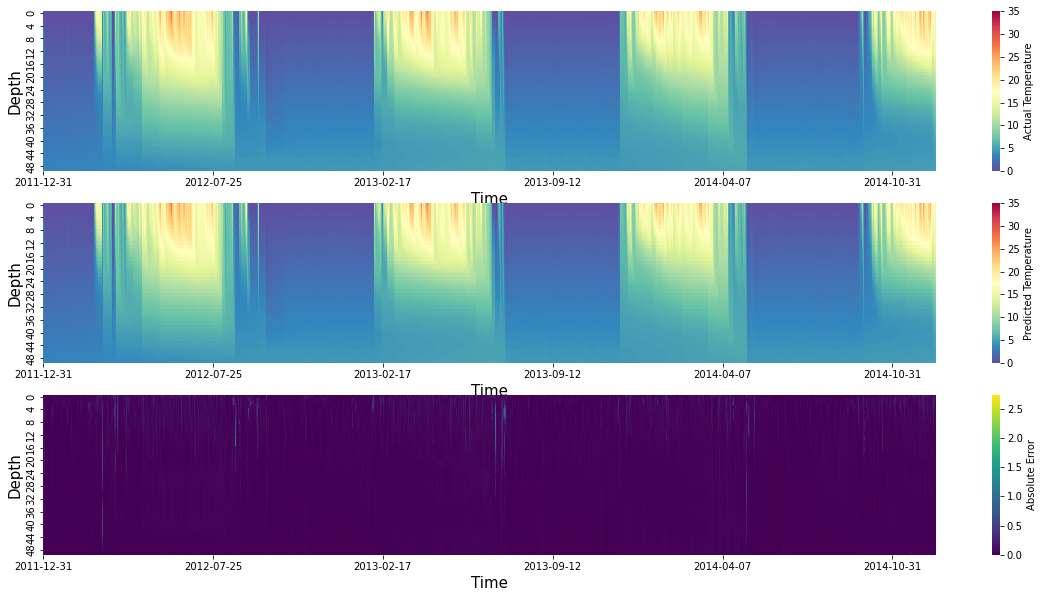

In [23]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

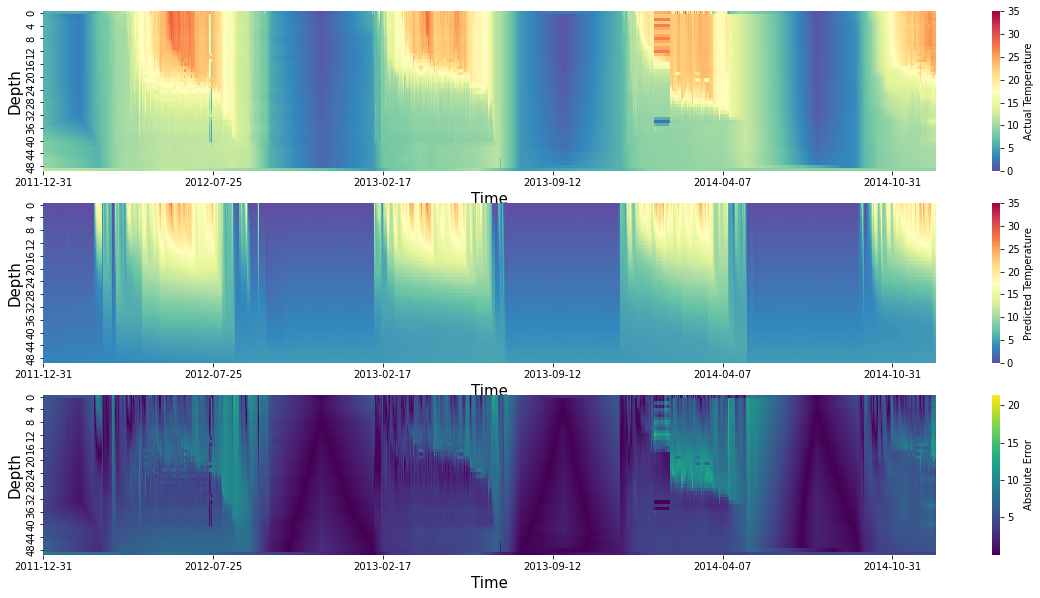

In [24]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [25]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0090550585
RMSE of after m1 0.016522184
RMSE of after m3 0.019098237
RMSE of after m4 0.02671519
RMSE of after m0 0.010058648
RMSE of after m1 0.016627615
RMSE of after m3 0.028392063
RMSE of after m4 0.03786254
RMSE of after m0 0.011175206
RMSE of after m1 0.018848468
RMSE of after m3 0.016677001
RMSE of after m4 0.028951336
RMSE of after m0 0.011941654
RMSE of after m1 0.019957943
RMSE of after m3 0.012618293
RMSE of after m4 0.020773193
RMSE of after m0 0.011727795
RMSE of after m1 0.02048253
RMSE of after m3 0.013001552
RMSE of after m4 0.021076027
RMSE of after m0 0.010224279
RMSE of after m1 0.019635735
RMSE of after m3 0.02228669
RMSE of after m4 0.025835821
RMSE of after m0 0.008626026
RMSE of after m1 0.01620574
RMSE of after m3 0.03327698
RMSE of after m4 0.031969585
RMSE of after m0 0.009490272
RMSE of after m1 0.015358796
RMSE of after m3 0.023268912
RMSE of after m4 0.027222903
RMSE of after m0 0.010674276
RMSE of after m1 0.017634274
RMSE of after m3 0.

RMSE of after m0 0.00701507
RMSE of after m1 0.010015175
RMSE of after m3 0.046667907
RMSE of after m4 0.048015352
RMSE of after m0 0.00987505
RMSE of after m1 0.012686832
RMSE of after m3 0.10598259
RMSE of after m4 0.09672293
RMSE of after m0 0.008555338
RMSE of after m1 0.013778052
RMSE of after m3 0.05177918
RMSE of after m4 0.061640345
RMSE of after m0 0.008458383
RMSE of after m1 0.012656327
RMSE of after m3 0.068850964
RMSE of after m4 0.07340243
RMSE of after m0 0.0073385816
RMSE of after m1 0.00959897
RMSE of after m3 0.050607327
RMSE of after m4 0.044568144
RMSE of after m0 0.0064122505
RMSE of after m1 0.009641298
RMSE of after m3 0.041827194
RMSE of after m4 0.03691131
RMSE of after m0 0.0066470597
RMSE of after m1 0.009231579
RMSE of after m3 0.07287598
RMSE of after m4 0.07176267
RMSE of after m0 0.007778761
RMSE of after m1 0.0056183287
RMSE of after m3 0.07103386
RMSE of after m4 0.045096178
RMSE of after m0 0.0108512975
RMSE of after m1 0.011498152
RMSE of after m3 0.2

RMSE of after m1 0.017933648
RMSE of after m3 0.03410931
RMSE of after m4 0.033002876
RMSE of after m0 0.015168714
RMSE of after m1 0.018412666
RMSE of after m3 0.01812183
RMSE of after m4 0.018296802
RMSE of after m0 0.015327407
RMSE of after m1 0.02091872
RMSE of after m3 0.034208473
RMSE of after m4 0.033898573
RMSE of after m0 0.01415858
RMSE of after m1 0.015806895
RMSE of after m3 0.05068364
RMSE of after m4 0.049368124
RMSE of after m0 0.016523397
RMSE of after m1 0.014103757
RMSE of after m3 0.048098043
RMSE of after m4 0.0476903
RMSE of after m0 0.017184312
RMSE of after m1 0.016877146
RMSE of after m3 0.015500584
RMSE of after m4 0.0151804
RMSE of after m0 0.017148841
RMSE of after m1 0.018557394
RMSE of after m3 0.029311895
RMSE of after m4 0.028998638
RMSE of after m0 0.016075712
RMSE of after m1 0.0139965415
RMSE of after m3 0.028380571
RMSE of after m4 0.027951067
RMSE of after m0 0.017038234
RMSE of after m1 0.016146246
RMSE of after m3 0.030720176
RMSE of after m4 0.030

RMSE of after m3 0.08148679
RMSE of after m4 0.07518771
RMSE of after m0 0.017370176
RMSE of after m1 0.0236657
RMSE of after m3 0.10145734
RMSE of after m4 0.09348822
RMSE of after m0 0.019359026
RMSE of after m1 0.02599844
RMSE of after m3 0.03388476
RMSE of after m4 0.030616997
RMSE of after m0 0.020198565
RMSE of after m1 0.026951628
RMSE of after m3 0.030749565
RMSE of after m4 0.027568752
RMSE of after m0 0.020453323
RMSE of after m1 0.027571296
RMSE of after m3 0.036115628
RMSE of after m4 0.032654695
RMSE of after m0 0.019821456
RMSE of after m1 0.0302185
RMSE of after m3 0.037250154
RMSE of after m4 0.033901893
RMSE of after m0 0.019916132
RMSE of after m1 0.029623514
RMSE of after m3 0.06355523
RMSE of after m4 0.062778346
RMSE of after m0 0.020188374
RMSE of after m1 0.026381321
RMSE of after m3 0.12353861
RMSE of after m4 0.12338992
RMSE of after m0 0.021996653
RMSE of after m1 0.027010528
RMSE of after m3 0.0967874
RMSE of after m4 0.09600069
RMSE of after m0 0.021282943
R

RMSE of after m1 0.009371482
RMSE of after m3 0.051244248
RMSE of after m4 0.044295173
RMSE of after m0 0.008335158
RMSE of after m1 0.010215317
RMSE of after m3 0.04683894
RMSE of after m4 0.03811513
RMSE of after m0 0.006883945
RMSE of after m1 0.009278928
RMSE of after m3 0.0109176785
RMSE of after m4 0.013013245
RMSE of after m0 0.0083124675
RMSE of after m1 0.008740981
RMSE of after m3 0.045617837
RMSE of after m4 0.038333356
RMSE of after m0 0.010002536
RMSE of after m1 0.00951149
RMSE of after m3 0.02575295
RMSE of after m4 0.024654748
RMSE of after m0 0.009463639
RMSE of after m1 0.009538235
RMSE of after m3 0.04125453
RMSE of after m4 0.03640684
RMSE of after m0 0.009088805
RMSE of after m1 0.010608837
RMSE of after m3 0.057533436
RMSE of after m4 0.05478502
RMSE of after m0 0.009613043
RMSE of after m1 0.012508695
RMSE of after m3 0.03594524
RMSE of after m4 0.036582526
RMSE of after m0 0.0070822802
RMSE of after m1 0.00836789
RMSE of after m3 0.06342449
RMSE of after m4 0.05

RMSE of after m1 0.014148939
RMSE of after m3 0.023205938
RMSE of after m4 0.029880667
RMSE of after m0 0.010054149
RMSE of after m1 0.016864546
RMSE of after m3 0.019890852
RMSE of after m4 0.032135602
RMSE of after m0 0.010035212
RMSE of after m1 0.015559104
RMSE of after m3 0.025204744
RMSE of after m4 0.031078141
RMSE of after m0 0.009400991
RMSE of after m1 0.016716305
RMSE of after m3 0.016789826
RMSE of after m4 0.02694911
RMSE of after m0 0.012549094
RMSE of after m1 0.020786064
RMSE of after m3 0.038370572
RMSE of after m4 0.04565992
RMSE of after m0 0.0071649873
RMSE of after m1 0.013358704
RMSE of after m3 0.030551473
RMSE of after m4 0.034477886
RMSE of after m0 0.00854526
RMSE of after m1 0.01327171
RMSE of after m3 0.039458487
RMSE of after m4 0.03719982
RMSE of after m0 0.009075928
RMSE of after m1 0.014131409
RMSE of after m3 0.019610303
RMSE of after m4 0.026988996
RMSE of after m0 0.008820393
RMSE of after m1 0.013943333
RMSE of after m3 0.027775507
RMSE of after m4 0

RMSE of after m0 0.010001555
RMSE of after m1 0.015385875
RMSE of after m3 0.044282064
RMSE of after m4 0.044171676
RMSE of after m0 0.010845656
RMSE of after m1 0.017901212
RMSE of after m3 0.04494737
RMSE of after m4 0.05168158
RMSE of after m0 0.012466554
RMSE of after m1 0.021123234
RMSE of after m3 0.07269841
RMSE of after m4 0.08276011
RMSE of after m0 0.0123182945
RMSE of after m1 0.0224183
RMSE of after m3 0.026142703
RMSE of after m4 0.04021856
RMSE of after m0 0.008413073
RMSE of after m1 0.016880069
RMSE of after m3 0.016923621
RMSE of after m4 0.023854205
RMSE of after m0 0.0097714225
RMSE of after m1 0.016699605
RMSE of after m3 0.023981227
RMSE of after m4 0.028637076
RMSE of after m0 0.010889236
RMSE of after m1 0.01825191
RMSE of after m3 0.028276647
RMSE of after m4 0.03226021
RMSE of after m0 0.01116537
RMSE of after m1 0.020111546
RMSE of after m3 0.015383753
RMSE of after m4 0.030392883
RMSE of after m0 0.0119486535
RMSE of after m1 0.021668786
RMSE of after m3 0.01

RMSE of after m1 0.006935313
RMSE of after m3 0.041031953
RMSE of after m4 0.03359187
RMSE of after m0 0.00662818
RMSE of after m1 0.007690817
RMSE of after m3 0.1067043
RMSE of after m4 0.09736273
RMSE of after m0 0.0067888424
RMSE of after m1 0.00459844
RMSE of after m3 0.036716986
RMSE of after m4 0.02995281
RMSE of after m0 0.009777592
RMSE of after m1 0.007939709
RMSE of after m3 0.04609556
RMSE of after m4 0.03997994
RMSE of after m0 0.011131741
RMSE of after m1 0.012932649
RMSE of after m3 0.1737849
RMSE of after m4 0.16515914
RMSE of after m0 0.010972443
RMSE of after m1 0.012642712
RMSE of after m3 0.07754236
RMSE of after m4 0.07544407
RMSE of after m0 0.010294792
RMSE of after m1 0.012126394
RMSE of after m3 0.038529053
RMSE of after m4 0.03599063
RMSE of after m0 0.00953863
RMSE of after m1 0.011659593
RMSE of after m3 0.037094284
RMSE of after m4 0.034533717
RMSE of after m0 0.009118008
RMSE of after m1 0.011087352
RMSE of after m3 0.038350668
RMSE of after m4 0.03618479
R

RMSE of after m1 0.016089717
RMSE of after m3 0.01366987
RMSE of after m4 0.0114426175
RMSE of after m0 0.023255311
RMSE of after m1 0.018338462
RMSE of after m3 0.018359896
RMSE of after m4 0.016027102
RMSE of after m0 0.023023862
RMSE of after m1 0.018994804
RMSE of after m3 0.020927753
RMSE of after m4 0.018302433
RMSE of after m0 0.021758737
RMSE of after m1 0.020131541
RMSE of after m3 0.022871664
RMSE of after m4 0.020616833
RMSE of after m0 0.020724276
RMSE of after m1 0.022484845
RMSE of after m3 0.022541843
RMSE of after m4 0.020533381
RMSE of after m0 0.022152018
RMSE of after m1 0.024072763
RMSE of after m3 0.018702103
RMSE of after m4 0.016519658
RMSE of after m0 0.021747153
RMSE of after m1 0.024342813
RMSE of after m3 0.018905992
RMSE of after m4 0.01646667
RMSE of after m0 0.020412374
RMSE of after m1 0.025558328
RMSE of after m3 0.020607647
RMSE of after m4 0.017435098
RMSE of after m0 0.019778788
RMSE of after m1 0.023885854
RMSE of after m3 0.023528563
RMSE of after m

RMSE of after m0 0.009437464
RMSE of after m1 0.008104501
RMSE of after m3 0.039951127
RMSE of after m4 0.039765667
RMSE of after m0 0.008577608
RMSE of after m1 0.007010205
RMSE of after m3 0.045965623
RMSE of after m4 0.04022127
RMSE of after m0 0.008481176
RMSE of after m1 0.007136303
RMSE of after m3 0.018582711
RMSE of after m4 0.020582253
RMSE of after m0 0.008067063
RMSE of after m1 0.006384515
RMSE of after m3 0.04274371
RMSE of after m4 0.041884214
RMSE of after m0 0.010059019
RMSE of after m1 0.008106481
RMSE of after m3 0.17208926
RMSE of after m4 0.17231679
RMSE of after m0 0.0124300625
RMSE of after m1 0.012325713
RMSE of after m3 0.03842532
RMSE of after m4 0.03793697
RMSE of after m0 0.01124705
RMSE of after m1 0.010900203
RMSE of after m3 0.07787107
RMSE of after m4 0.076422736
RMSE of after m0 0.009897156
RMSE of after m1 0.00889066
RMSE of after m3 0.19263014
RMSE of after m4 0.18987273
RMSE of after m0 0.0104162255
RMSE of after m1 0.012554957
RMSE of after m3 0.0718

RMSE of after m3 0.018485527
RMSE of after m4 0.024898103
RMSE of after m0 0.010876992
RMSE of after m1 0.016725698
RMSE of after m3 0.023248605
RMSE of after m4 0.032067783
RMSE of after m0 0.00848824
RMSE of after m1 0.015367613
RMSE of after m3 0.017600255
RMSE of after m4 0.021439942
RMSE of after m0 0.0068900324
RMSE of after m1 0.012252494
RMSE of after m3 0.03053418
RMSE of after m4 0.026672842
RMSE of after m0 0.008488133
RMSE of after m1 0.010653532
RMSE of after m3 0.024913892
RMSE of after m4 0.025565403
RMSE of after m0 0.008612782
RMSE of after m1 0.011969821
RMSE of after m3 0.0138451
RMSE of after m4 0.020996176
RMSE of after m0 0.0090677235
RMSE of after m1 0.012567751
RMSE of after m3 0.030690953
RMSE of after m4 0.02928094
RMSE of after m0 0.009093659
RMSE of after m1 0.014870563
RMSE of after m3 0.022595944
RMSE of after m4 0.028656034
RMSE of after m0 0.008468483
RMSE of after m1 0.015359696
RMSE of after m3 0.0073383176
RMSE of after m4 0.018101184
RMSE of after m0

RMSE of after m1 0.015561638
RMSE of after m3 0.010766581
RMSE of after m4 0.022162462
RMSE of after m0 0.010656525
RMSE of after m1 0.017202076
RMSE of after m3 0.009894572
RMSE of after m4 0.021774946
RMSE of after m0 0.010095272
RMSE of after m1 0.016722163
RMSE of after m3 0.017205097
RMSE of after m4 0.021885235
RMSE of after m0 0.009979881
RMSE of after m1 0.017790815
RMSE of after m3 0.015239577
RMSE of after m4 0.022742577
RMSE of after m0 0.009472794
RMSE of after m1 0.016487578
RMSE of after m3 0.022092354
RMSE of after m4 0.026406411
RMSE of after m0 0.01097203
RMSE of after m1 0.016643627
RMSE of after m3 0.03167465
RMSE of after m4 0.042067725
RMSE of after m0 0.010432469
RMSE of after m1 0.016455043
RMSE of after m3 0.018176168
RMSE of after m4 0.025036551
RMSE of after m0 0.010739154
RMSE of after m1 0.017175391
RMSE of after m3 0.018432884
RMSE of after m4 0.024211641
RMSE of after m0 0.010500145
RMSE of after m1 0.018007541
RMSE of after m3 0.01470196
RMSE of after m4 

RMSE of after m1 0.019849973
RMSE of after m3 0.055207092
RMSE of after m4 0.06618319
RMSE of after m0 0.009768387
RMSE of after m1 0.018547503
RMSE of after m3 0.04046984
RMSE of after m4 0.054848187
RMSE of after m0 0.008445527
RMSE of after m1 0.015363542
RMSE of after m3 0.028633146
RMSE of after m4 0.037916694
RMSE of after m0 0.008321675
RMSE of after m1 0.014090205
RMSE of after m3 0.03200858
RMSE of after m4 0.042815007
RMSE of after m0 0.008848679
RMSE of after m1 0.014215562
RMSE of after m3 0.053026844
RMSE of after m4 0.047176138
RMSE of after m0 0.00836129
RMSE of after m1 0.013547519
RMSE of after m3 0.08425853
RMSE of after m4 0.06705604
RMSE of after m0 0.008432809
RMSE of after m1 0.014397762
RMSE of after m3 0.05436204
RMSE of after m4 0.05152235
RMSE of after m0 0.008963771
RMSE of after m1 0.01638095
RMSE of after m3 0.03624754
RMSE of after m4 0.04171018
RMSE of after m0 0.008056452
RMSE of after m1 0.014520785
RMSE of after m3 0.028297648
RMSE of after m4 0.033007

RMSE of after m4 0.4484767
RMSE of after m0 0.01578778
RMSE of after m1 0.059241936
RMSE of after m3 0.27252367
RMSE of after m4 0.2718765
RMSE of after m0 0.021384833
RMSE of after m1 0.096878275
RMSE of after m3 0.20905666
RMSE of after m4 0.21201554
RMSE of after m0 0.023569232
RMSE of after m1 0.035275068
RMSE of after m3 0.05476607
RMSE of after m4 0.05706039
RMSE of after m0 0.023045195
RMSE of after m1 0.037823733
RMSE of after m3 0.039644007
RMSE of after m4 0.03915208
RMSE of after m0 0.021686757
RMSE of after m1 0.03926555
RMSE of after m3 0.051403943
RMSE of after m4 0.051326275
RMSE of after m0 0.02214269
RMSE of after m1 0.03707861
RMSE of after m3 0.049694974
RMSE of after m4 0.049870867
RMSE of after m0 0.021036074
RMSE of after m1 0.038402267
RMSE of after m3 0.04033966
RMSE of after m4 0.037078872
RMSE of after m0 0.020326853
RMSE of after m1 0.038672347
RMSE of after m3 0.044406276
RMSE of after m4 0.04368606
RMSE of after m0 0.02470421
RMSE of after m1 0.029970624
RM

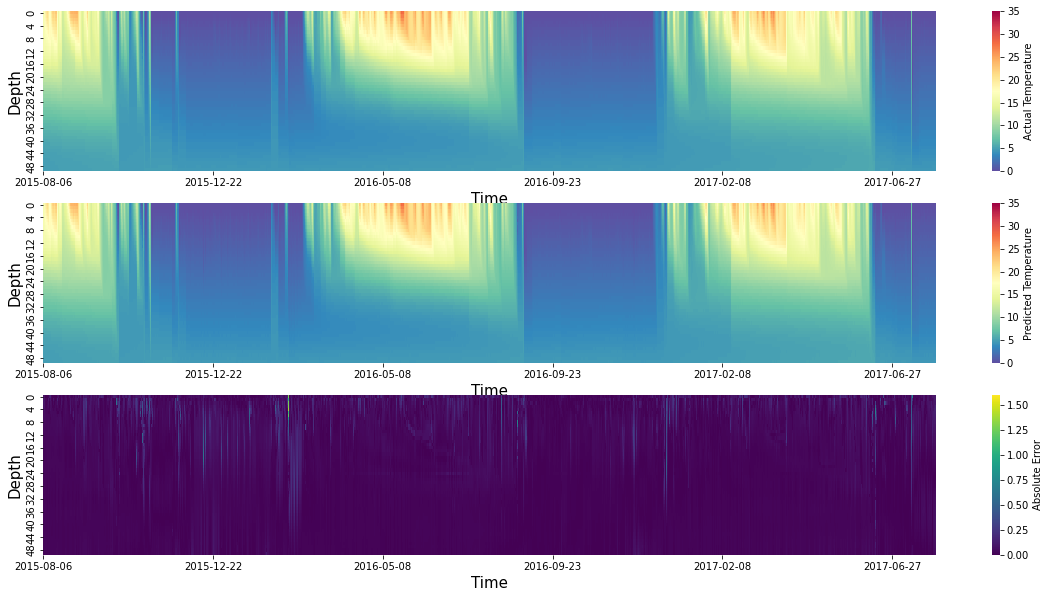

In [26]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

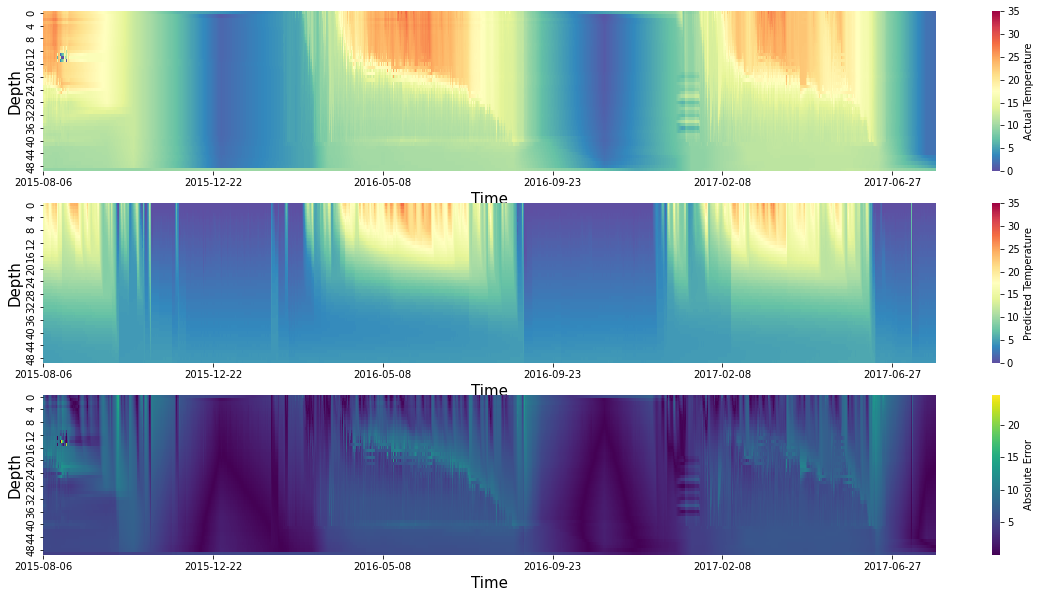

In [27]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [28]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.04349529181305193, Train L2 Error: 0.0057276601087314395
Test RMSE: 0.058766599809652265, Train L2 Error: 0.007387817348391442


## Mixing Model

## Convection Model

In [29]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.016564466585520927, Train L2 Error: 0.0021814161585095035
Test RMSE: 0.018082867571663358, Train L2 Error: 0.0022734152265340805


## Ice Model

In [30]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.014016497076078948, Train L2 Error: 0.0018445259825475508
Test RMSE: 0.01633510608431941, Train L2 Error: 0.0020521246787989266


# Finetuning

In [31]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [32]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [33]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [ ]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out3 = torch.tensor(train_mean[m3_output_column_ix[0]]).float().to(device)
std_out3 = torch.tensor(train_std[m3_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m4_pred = ice_model(m4_input)
        loss_m4 = criterion(m4_pred, x[:, m4_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)

        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out3)/std_out3
        
        loss_m3 = criterion(m3_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m3
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:09<2:30:33,  9.04s/it]

Epoch : 0, Train_loss: 0.8233822223840161, Loss m0: 1.2437386282922334e-05, Loss m1: 0.011170538487326735,  Loss m3: 0.8233822223840161, Loss m4: 1.4927743421425768e-05


  5%|▌         | 51/1000 [08:06<2:12:46,  8.39s/it]

Epoch : 50, Train_loss: 0.14238552666766185, Loss m0: 1.2437386282922334e-05, Loss m1: 0.7628235563786915,  Loss m3: 0.14238552666766185, Loss m4: 1.4927743421425768e-05


 10%|█         | 101/1000 [15:51<3:03:09, 12.22s/it]

Epoch : 100, Train_loss: 0.12709113160066818, Loss m0: 1.2437386282922334e-05, Loss m1: 0.7945656489323546,  Loss m3: 0.12709113160066818, Loss m4: 1.4927743421425768e-05


 15%|█▌        | 151/1000 [24:41<1:57:34,  8.31s/it]

Epoch : 150, Train_loss: 0.11672179982407285, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8082141721625877,  Loss m3: 0.11672179982407285, Loss m4: 1.4927743421425768e-05


 20%|██        | 201/1000 [31:39<1:54:47,  8.62s/it]

Epoch : 200, Train_loss: 0.10860798160955121, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8196650365631938,  Loss m3: 0.10860798160955121, Loss m4: 1.4927743421425768e-05


 25%|██▌       | 251/1000 [38:35<1:41:20,  8.12s/it]

Epoch : 250, Train_loss: 0.1021775887622197, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8290338163997114,  Loss m3: 0.1021775887622197, Loss m4: 1.4927743421425768e-05


 30%|███       | 301/1000 [45:23<1:31:51,  7.88s/it]

Epoch : 300, Train_loss: 0.09693368933950308, Loss m0: 1.2437386282922334e-05, Loss m1: 0.8373416750615106,  Loss m3: 0.09693368933950308, Loss m4: 1.4927743421425768e-05


 33%|███▎      | 334/1000 [50:00<1:30:54,  8.19s/it]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [ ]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [ ]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

In [ ]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Mixing Model

## Convection Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Ice Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

# Compute Model Similarity after Finetuning

In [ ]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [ ]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
# Freeze all models again and compute finetuned diffusivity values

In [ ]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [ ]:
PATH = f"./saved_models/diffusion_model_finetuned.pth"
torch.save(heat_diff_model.state_dict(), PATH)

In [ ]:
def plot_output_freeLimits(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r')
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r')
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

In [ ]:
plot_output_freeLimits(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output_freeLimits(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))